# Notebook 24: Null other_wind checks

In this notebook we check whether the `other_wind` option in MESA overrides all other mass loss.

In [1]:
# nb_id is used to identify this notebook's output files (i.e., figures) if there are any
# it should match the first two digits in the notebook's title
nb_id = 40

## Imports

In [2]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from matplotlib.lines import Line2D

import astropy.units as u
import astropy.constants as ct
from scipy.signal import find_peaks

import mesa_reader as mr
import mesaPlot as mp
import tulips as tp

import sys
sys.path.append('..')
from src.star import fix_unit

/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <

In [3]:
ROOT = Path.cwd().parent
PROJECT_FOLDER = ROOT/'mesa/sse_wind_test'
FIGURE_FOLDER = Path(f'./output/nb{nb_id}/figures')
FIGURE_FOLDER.mkdir(parents=True, exist_ok=True)

In [4]:
plt.style.use('./plotstyle.mplstyle')

## Definitions

### Constants

In [5]:
ZSUN = 0.014

### Utilities

In [6]:
def savefig(fig, fname):
    """Saves png, pdf and eps figure files to a nb-specific folder."""
    fname = f'nb{nb_id}_{fname}'
    plt.savefig(FIGURE_FOLDER/(fname+'.png'), bbox_inches='tight')
    plt.savefig(FIGURE_FOLDER/(fname+'.pdf'), bbox_inches='tight')
    plt.savefig(FIGURE_FOLDER/(fname+'.eps'), bbox_inches='tight')

In [7]:
def normarr(arr):
    return (arr-min(arr))/(max(arr)-min(arr))

In [8]:
def get_model_folder(model_id, verbose=True):
    """Finds model folder given its id."""
    matches = list(PROJECT_FOLDER.glob(f'{model_id}_*'))
    
    if len(matches) > 1:
        if verbose:
            print('\n'.join((
                f'Multiple matches for id {model_id} found in {PROJECT_FOLDER}:',
                *[str(match) for match in matches]
            )))
        return
    elif len(matches) != 0:
        match = matches[0]
        if verbose:
            print(f'Found match {match}')
        return match
    else:
        if verbose:
            print(f'No matches found in {PROJECT_FOLDER}')
        return           

In [9]:
def get_model_dict(grid_folder):
    """Given a model folder, loads the paths of specific stars into a 
    m1, p_orb dictionary."""
    d = dict()
    for model_folder in grid_folder.glob('m*_w*'):
        if model_folder.suffix == '.log':
            continue
        m, w = model_folder.name.replace('d', 'e').split('_')        
        m = f'{float(m.lstrip("m")):.1f}'
        w = float(w.lstrip('w'))
        p = 2*np.pi / w / (60*60*24)
        p = f'{p:.2f}'
        if m not in d.keys():
            d[m] = dict()
        d[m][p] = model_folder
    return d

In [10]:
def mesareader_operator(expression):
    """Converts strings into operations between mesareader columns.
    
    Supports summation, subtraction, multiplication and division."""
    operations = ['+', '-', '*', '/', '(', ')']
    
    mr_expression = ''
    attr = ''
    char_i = 0
    while char_i < len(expression):
        char = expression[char_i]
        if char not in operations:
            mr_expression += f'h.__getattr__("{char}'
        else:
            mr_expression += f'{char}h.__getattr__("'
        char_i += 1
        char = expression[char_i]
        while char not in operations+['']:
            attr += char
            char_i += 1
            try:
                char = expression[char_i]
            except IndexError:
                char = ''
        attr = f'{attr}"){char}'
        mr_expression += attr
        attr = ''
        char_i += 1
            
    return mr_expression


### Plotting

In [11]:
def history_plot(ax, model_dict_list, model_styles, model_labels, x, y, invert_xaxis, invert_yaxis, title=False,
                 label_period=True):
    """2D line plot for all m1, p_orb combinations from a given model.
    
    Assumes a single m1 per dict.
    """
    
    #base_dict = model_dict_list[0]
    #all_paths = [base_dict[k1][k2] for k1 in base_dict.keys() for k2 in base_dict[k1].keys()] 
    
    all_periods = []
    for dict_ in model_dict_list:
        for k1 in dict_.keys():
            for k2 in dict_[k1].keys():
                all_periods.append(k2)
    all_periods = np.unique(all_periods)
    all_periods = all_periods[np.argsort([float(p) for p in all_periods])]
    
    period_color_dict = {}
    for i, p in enumerate(all_periods):
        period_color_dict[p] = cm.jet(i/len(all_periods))
    
    handles = []
    for p_key in all_periods:
        p = float(p_key)
        c = period_color_dict[p_key]
        
        if label_period:
            label = f'${p:.2f}\\,\\mathrm{{d}}$'
        else:
            label = None
        handles.append(Line2D([], [], ls='-', color=c, label=label))
               
        for dict_, ls in zip(model_dict_list, model_styles):
            dict_ = dict_[list(dict_.keys())[0]]
            try:
                model_path = dict_[p_key]
            except:
                continue
            else:
                h = mr.MesaData(str(model_path/'LOGS/history.data'))
                x_data = eval(mesareader_operator(x))
                y_data = eval(mesareader_operator(y))
                ax.plot(x_data, y_data, ls=ls, color=c, lw=1)
                
    if invert_xaxis:
        ax.invert_xaxis()
    if invert_yaxis:
        ax.invert_yaxis()
    
    if title:
        ax.set_title(model_labels[0], fontsize=20)
    else:
        for ls, label in zip(model_styles, model_labels):
            handles.append(Line2D([], [], color='k', ls=ls, label=label))
    ax.legend(handles=handles, frameon=False, loc='upper left', bbox_to_anchor=(1, 1))
    
    return ax

In [12]:
def hr_diagram_tracks(
    ax,
    models_to_plot,
    model_style_list,
    xlim, 
    ylim,
    legend=True,
    labelx=True, 
    labely=True
    ):
    model_dict_list = model_dicts[models_to_plot]
    model_label_list = model_labels[models_to_plot]
    
    settings = dict(
        x='log_Teff',
        y='log_L',
        invert_xaxis=True,
        invert_yaxis=False,
        model_dict_list=model_dict_list,
        model_styles=model_style_list,
        model_labels=model_label_list,
        label_period=legend
        )

    ax = history_plot(ax, **settings)

    if labelx:
        ax.set_xlabel('$\\log T_\\mathrm{eff}/\\mathrm{K}$')
    if labely:
        ax.set_ylabel('$\\log L/\\mathrm{L}_\\odot$')

    # GUIDELINES

    ## Humphreys-Davidson limit and LBV regime
    hd_x = np.linspace(*xlim, 100)
    hd_y = hd_limit(hd_x)
    ax.plot(hd_x, hd_y, 'k--', lw=1)
    ax.fill_between(hd_x, hd_y, [ylim[1]]*len(hd_y), color='k', alpha=0.05)

    ## Lines of constant radius
    r = 1
    ax.plot(hd_x, log_l_const_rad(hd_x, r), 'k--', lw=0.5, alpha=0.5)
    ax.text(
        hd_x[np.argmin(np.abs(log_l_const_rad(hd_x, r)-ylim[0]))], 
        ylim[0]-0.01, f'${r}\\,\\mathrm{{R}}_\\odot$',
        ha='center',
        va='top', 
        fontsize=16
        )
    r = 5
    ax.plot(hd_x, log_l_const_rad(hd_x, r), 'k--', lw=0.5, alpha=0.5)
    ax.text(
        hd_x[np.argmin(np.abs(log_l_const_rad(hd_x, r)-ylim[0]))], 
        ylim[0]-0.01, f'${r}\\,\\mathrm{{R}}_\\odot$',
        ha='center',
        va='top', 
        fontsize=16
        )
    r = 8
    ax.plot(hd_x, log_l_const_rad(hd_x, r), 'k--', lw=0.5, alpha=0.5)
    ax.text(
        hd_x[np.argmin(np.abs(log_l_const_rad(hd_x, r)-ylim[0]))], 
        ylim[0]-0.01, f'${r}\\,\\mathrm{{R}}_\\odot$',
        ha='center',
        va='top', 
        fontsize=16
        )
    r = 10
    ax.plot(hd_x, log_l_const_rad(hd_x, r), 'k--', lw=0.5, alpha=0.5)
    ax.text(
        hd_x[np.argmin(np.abs(log_l_const_rad(hd_x, r)-ylim[-1]))],
        ylim[-1], f'${r}\\,\\mathrm{{R}}_\\odot$',
        ha='center', 
        va='bottom', 
        fontsize=16
        )
    r = 20
    ax.plot(hd_x, log_l_const_rad(hd_x, r), 'k--', lw=0.5, alpha=0.5)
    ax.text(
        hd_x[np.argmin(np.abs(log_l_const_rad(hd_x, r)-ylim[-1]))],
        ylim[-1], f'${r}\\,\\mathrm{{R}}_\\odot$',
        ha='center', 
        va='bottom', 
        fontsize=16
        )
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    return ax

### Winds

In [13]:
def _sanders_winds(l, z):
    logz = np.log10(z/ZSUN)
    alpha = 0.32 * logz + 1.4
    l0 = 10.**(-0.87*logz + 5.06)
    mdot10 = 10.**(-0.75*logz - 4.06)
    
    if l < l0:
        log_power_term = 0
    else:
        log_power_term = np.log10(l/l0) ** alpha
        
    w = mdot10 * log_power_term * (l/(10*l0))**0.75
    
    return w

def _vink2017_winds(l, z):
    log_mdot = - 13.3 + 1.36*np.log10(l) + 0.61*np.log10(z/ZSUN)
    return 10.**log_mdot

def _vink2001_winds(l, t, m, z):
    Teff_jump = 1e3*(61.2 + 2.59*(-13.636 + 0.889*np.log10(z/ZSUN)))
    
    if t > 27.5e3:
        a = 1
    elif t < 22.5e3:
        a = 0
    else:
        dt = 100
        if t > Teff_jump + dt:
            a = 1
        elif t < Teff_jump - dt:
            a = 0
        else:
            a = (t - (Teff_jump - dt)) / (2*dt)
    
    if a > 0:
        vinf_div_vesc = 2.6
        vinf_div_vesc = vinf_div_vesc * (z/ZSUN)**0.13
        log_mdot = (
            - 6.697
            + 2.194 * np.log10(l/1e5)
            - 1.313 * np.log10(m/3e1)  
            - 1.226 * np.log10(vinf_div_vesc/2e0)              
            + 0.933 * np.log10(t/4e4) 
            - 10.92 * np.log10(t/4e4)**2
            + 0.85 * np.log10(z/ZSUN)
            )
        mdot1 = 10.**log_mdot
    else:
        mdot1 = 0
        
    if a < 1:
        vinf_div_vesc = 1.3    
        vinf_div_vesc = vinf_div_vesc * (z/ZSUN)**0.13
        log_mdot = (
            - 6.688 
            + 2.210 * np.log10(l/1e5) 
            - 1.339 * np.log10(m/3e1) 
            - 1.601 * np.log10(vinf_div_vesc/2)
            + 1.07 * np.log10(t/2e4) 
            + 0.85 * np.log10(z/ZSUN)
            )
        mdot2 = 10.**log_mdot
    else:
        mdot2 = 0
        
    w = a*mdot1 + (1-a)*mdot2  
    return w


In [14]:
vink2001_winds = np.vectorize(_vink2001_winds)
vink2017_winds = np.vectorize(_vink2017_winds)
sanders_winds = np.vectorize(_sanders_winds)

In [15]:
vink2001_test_teffs = np.logspace(3, 6, 100)
vink2001_test_mdots = vink2001_winds(1e6, vink2001_test_teffs, 60, ZSUN)

In [16]:
def _winds(l, t, m, z, y):
    
    v01 = vink2001_winds(l, t, m, z)
    v17 = vink2017_winds(l, z)
    s23 = sanders_winds(l, z)
    
    he_w = max(v17, s23)
    
    if y < 0.4:
        y_weight = 0
    elif y < 0.7:
        y_weight = (y - 0.4)/0.3
    else:
        y_weight = 1
        
    w = y_weight * he_w + (1-y_weight) * v01
    
    return w
    

In [17]:
winds = np.vectorize(_winds)

## Humphreys-Davidson limit

In [18]:
def log_l_const_rad(log_teff, r):
    teff = 10.**log_teff * u.K
    r = fix_unit(r, u.Rsun)
    log_l = np.log10(4*np.pi*ct.sigma_sb * teff**4 * r**2 / u.Lsun)
    return log_l
log_l_const_rad = np.vectorize(log_l_const_rad)

In [19]:
def hd_limit(log_teff):
    teff = 10**log_teff * u.K
    log_l = (
        np.log10(1.e5*np.sqrt(4*np.pi))
        + 0.5*np.log10(ct.sigma_sb * u.Rsun**2 * teff**4 / u.Lsun)
    ).value
    log_l = max(log_l, np.log10(6.e5))
    return log_l
hd_limit = np.vectorize(hd_limit)

# Analysis

Models run through helium burning are identified by a first digit 1 in the project folder. All use $Y_0=0.4$ and $\delta Y=0.3$.

In [20]:
model_ids = ['40', '41']
model_folders = np.array([get_model_folder(id) for id in model_ids])
model_dicts = np.array([get_model_dict(folder) for folder in model_folders])
model_labels = np.array([
    '$40\,\\mathrm{M}_\\odot,\\,Z_\\odot/10,\\Delta_\\mathrm{mesh}$',
    '$40\,\\mathrm{M}_\\odot,\\,Z_\\odot/10,\\Delta_\\mathrm{mesh}$, fix. wind'
])

Found match /mnt/home/ldesa/repos/cher/mesa/sse_wind_test/40_md1_m40_01zsun_nullwind_HeExh
Found match /mnt/home/ldesa/repos/cher/mesa/sse_wind_test/41_md1_m40_01zsun_fixwind_HeExh


Let's check the stellar models available.

In [21]:
print('Available models:')
for i in range(len(model_ids)):
    print(f'\t{model_folders[i]}:')
    keys1 = list(model_dicts[i].keys())
    keys1 = np.array(keys1)[np.argsort([float(key) for key in keys1])]
    for key1 in keys1:
        keys2 = list(model_dicts[i][key1].keys())
        keys2 = np.array(keys2)[np.argsort([float(key) for key in keys2])]
        print(f'\t\t(m1/msun) {key1}:')
        for key2 in keys2:
            print(f'\t\t\t(p_orb/d) {key2}')

Available models:
	/mnt/home/ldesa/repos/cher/mesa/sse_wind_test/40_md1_m40_01zsun_nullwind_HeExh:
		(m1/msun) 40.0:
			(p_orb/d) 0.73
			(p_orb/d) 0.80
			(p_orb/d) 0.90
			(p_orb/d) 1.00
			(p_orb/d) 1.10
			(p_orb/d) 1.19
	/mnt/home/ldesa/repos/cher/mesa/sse_wind_test/41_md1_m40_01zsun_fixwind_HeExh:
		(m1/msun) 40.0:
			(p_orb/d) 0.73
			(p_orb/d) 0.80
			(p_orb/d) 0.90
			(p_orb/d) 1.00
			(p_orb/d) 1.10
			(p_orb/d) 1.19


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


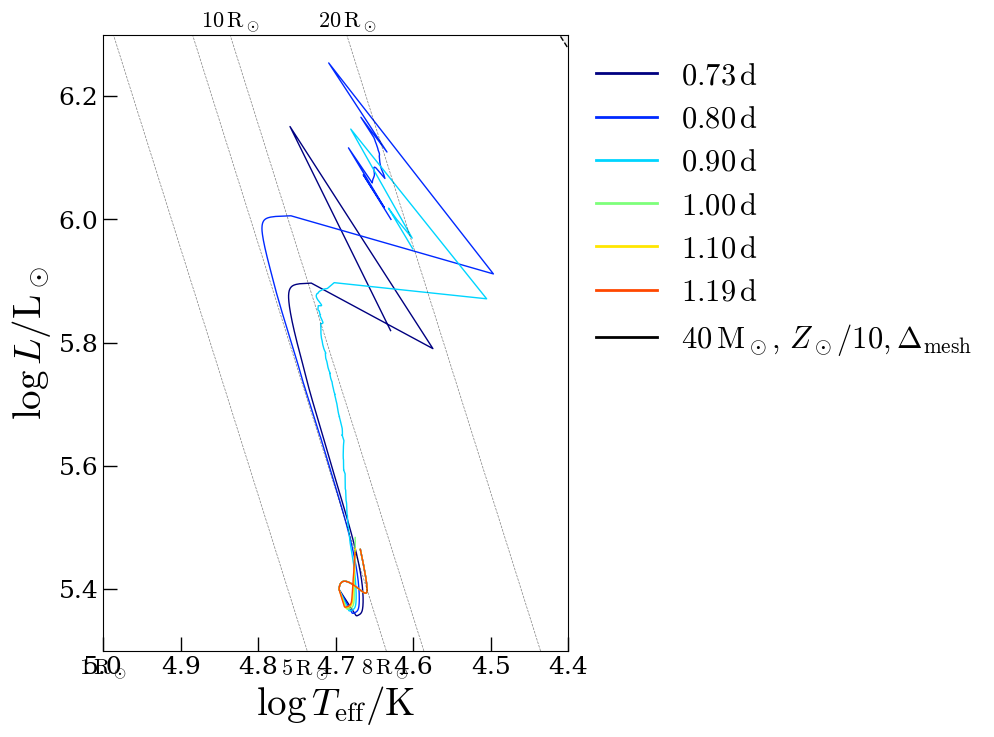

In [22]:

fig, axes = plt.subplots(figsize=(6, 8))

xlim = (5, 4.4)
ylim = (5.3, 6.3)

# PLOT M=40
ax = axes
models_to_plot = [0]
model_style_list = ['-']
legend = True
labelx = True
labely = True

ax = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
#ax.text(0.3, 0.2, '$40\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes)

savefig(fig, 'hr_allp_mass_comparison')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


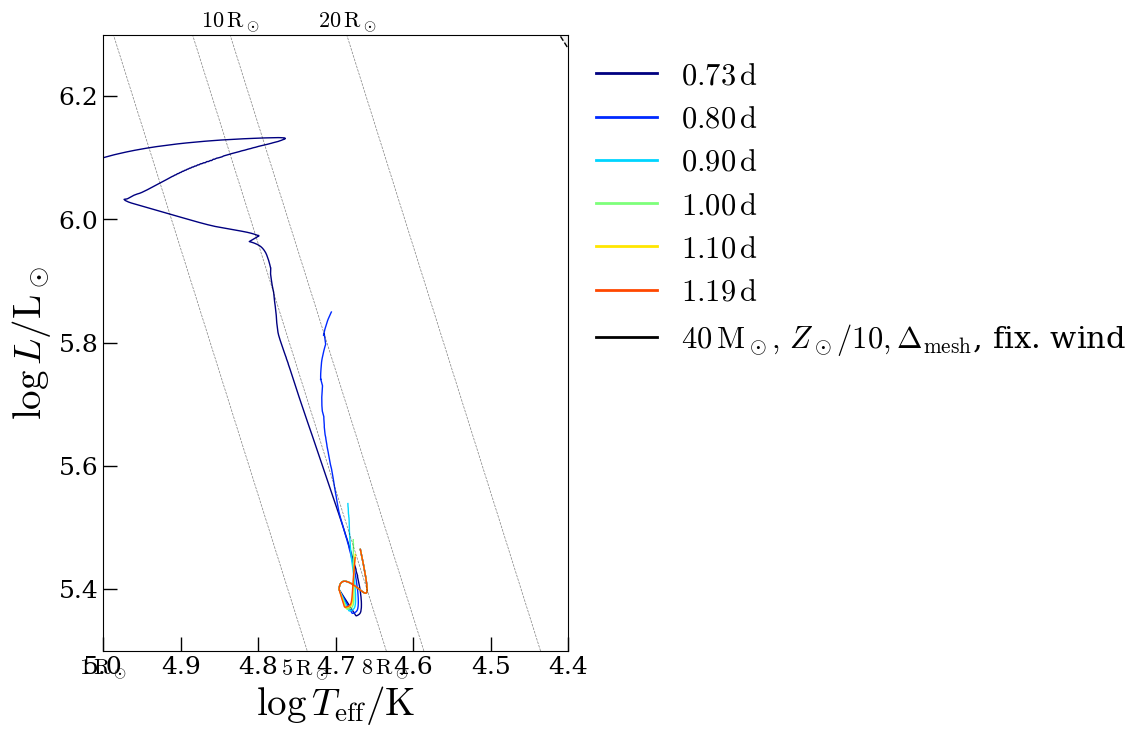

In [23]:

fig, axes = plt.subplots(figsize=(6, 8))

xlim = (5, 4.4)
ylim = (5.3, 6.3)

# PLOT M=40
ax = axes
models_to_plot = [1]
model_style_list = ['-']
legend = True
labelx = True
labely = True

ax = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
#ax.text(0.3, 0.2, '$40\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes)

savefig(fig, 'hr_allp_mass_comparison')

In [24]:
wind_test_model = model_dicts[1]['40.0']['0.73']

wind_test_h = mr.MesaData(str(wind_test_model/'LOGS/history.data'))

wind_test_omega = wind_test_h.surf_avg_omega_div_omega_crit
wind_test_start_i = np.where(wind_test_omega > 0)[0][0]

wind_test_l = 10.**wind_test_h.log_L[wind_test_start_i:]
wind_test_m = wind_test_h.star_mass[wind_test_start_i:]
wind_test_r = wind_test_h.radius[wind_test_start_i:]
wind_test_t = 10.**wind_test_h.log_Teff[wind_test_start_i:]
wind_test_y = wind_test_h.surface_he4[wind_test_start_i:]
wind_test_z = 0.014/10

v01_winds = vink2001_winds(wind_test_l, wind_test_t, wind_test_m, wind_test_z)
v17_winds = vink2017_winds(wind_test_l, wind_test_z)
s23_winds = sanders_winds(wind_test_l, wind_test_z)
full_winds = winds(wind_test_l, wind_test_t, wind_test_m, wind_test_z, wind_test_y)

/tmp/ipykernel_361774/1348775844.py:14: RuntimeWarning: divide by zero encountered in log10
  ax0.plot(x, np.log10(s23_winds), 'm--', label='Sanders20,23 winds')
/tmp/ipykernel_361774/1348775844.py:108: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


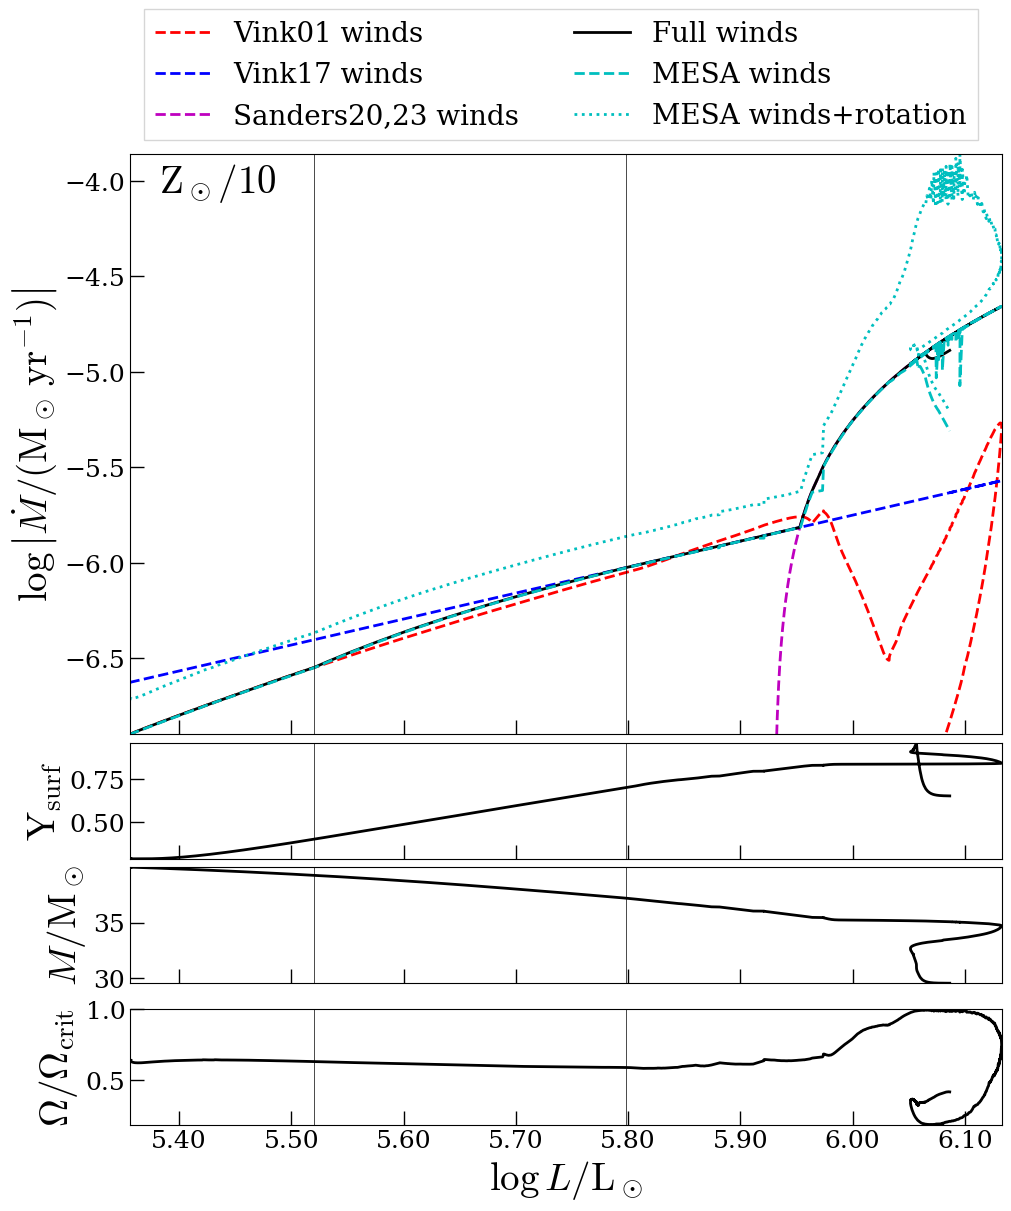

In [25]:

fig = plt.figure(figsize=(10, 12), layout='constrained')
gs = fig.add_gridspec(ncols=1, nrows=4, height_ratios=[1, 0.2, 0.2, 0.2], hspace=0)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[1,0])
ax2 = fig.add_subplot(gs[2,0])
ax3 = fig.add_subplot(gs[3,0])

x = np.log10(wind_test_l)
minx = min(x)
maxx = max(x)

ax0.plot(x, np.log10(v01_winds), 'r--', label='Vink01 winds')
ax0.plot(x, np.log10(v17_winds), 'b--', label='Vink17 winds')
ax0.plot(x, np.log10(s23_winds), 'm--', label='Sanders20,23 winds')
ax0.plot(x, np.log10(full_winds), 'k-', alpha=1, label='Full winds')

mesa_wind_rot = wind_test_h.log_abs_mdot[wind_test_start_i:]
mesa_wind = 10.**mesa_wind_rot
mesa_wind /= wind_test_h.rotational_mdot_boost[wind_test_start_i:]
mesa_wind = np.log10(mesa_wind)
miny = min(mesa_wind)
maxy = max(mesa_wind_rot)

ax0.plot(wind_test_h.log_L[wind_test_start_i:], mesa_wind, 'c--', label='MESA winds')
ax0.plot(wind_test_h.log_L[wind_test_start_i:], mesa_wind_rot, 'c:', label='MESA winds+rotation')

try: 
    y0_i = np.where(wind_test_h.surface_he4 >= 0.4)[0][0]
    y0_log_l = wind_test_h.log_L[y0_i]
except:
    y0_log_l = miny - 1
    
try:
    y1_i = np.where(wind_test_h.surface_he4 >= 0.7)[0][0]
    y1_log_l = wind_test_h.log_L[y1_i]
except:
    y0_log_l = maxy + 1
    
ax0.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax0.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
#ax0.text((y0_log_l+y1_log_l)/2, maxy-0.1, '$0.4<\\mathrm{Y}_\\mathrm{surf}<0.7$', ha='center', 
#         va='top', transform=ax0.transData, fontsize=16)

ax0.set_xlim(minx, maxx)
ax0.set_ylim(miny, maxy)
ax0.tick_params(direction='in')
ax0.set_xticklabels([])
ax0.set_ylabel('$\\log\\left|\\dot{M}/(\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1})\\right|$')
ax0.legend(frameon=True, fancybox=False, ncol=2, loc='lower left', bbox_to_anchor=(0, 1),
           fontsize=20)
ax0.text(0.1, 0.95, '$\\mathrm{Z}_\\odot/10$', transform=ax0.transAxes, ha='center', va='center')

## Surface He4

y = wind_test_h.surface_he4[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax1.plot(wind_test_h.log_L[wind_test_start_i:], y, color='k')

ax1.set_xticks(ax0.get_xticks())
ax1.set_xticklabels([])
ax1.set_xlim(ax0.get_xlim())

ax1.tick_params(direction='in')
ax1.set_ylabel('$\\mathrm{Y}_\\mathrm{surf}$')

ax1.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax1.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax1.set_ylim(miny, maxy)

## Mass

y = wind_test_h.star_mass[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax2.plot(wind_test_h.log_L[wind_test_start_i:], y, color='k')

ax2.set_xticks(ax0.get_xticks())
ax2.set_xticklabels([])
ax2.set_xlim(ax0.get_xlim())

ax2.tick_params(direction='in')
ax2.set_ylabel('$M/\\mathrm{M}_\\odot$')

ax2.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax2.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax2.set_ylim(miny, maxy)

# Surf avg omega/omega_crit

y = wind_test_h.surf_avg_omega_div_omega_crit[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax3.plot(wind_test_h.log_L[wind_test_start_i:], y, color='k')

ax3.set_xticks(ax0.get_xticks())
ax3.set_xticklabels([f'{t:.2f}' for t in ax3.get_xticks()])
ax3.set_xlim(ax0.get_xlim())

ax3.tick_params(direction='in')
ax3.set_ylabel('$\\Omega/\\Omega_\\mathrm{crit}$')
ax3.set_xlabel('$\\log L/\\mathrm{L}_\\odot$')

ax3.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax3.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax3.set_ylim(miny, maxy)

fig.subplots_adjust(hspace=0)

savefig(fig, 'windiag_m40_p073_zsun_div_10')